In [10]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import sys
sys.path.append('..')

from lib.WTTE import WTTE
from lib.ChurnEnsemble import ChurnEnsemble
from lib.utils import print_censored_rate, show_summary, transform_data

SEED = 42
np.random.seed(SEED)

In [11]:
config = dict(
    features=[
        'plan', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
        'failed', 'usage', 'usage_groups', 'usage_payments', 'momentum'
    ],
    params={}
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
max_sl = 24  # Maximum sequence length (0 = max length from data)
wlevel = 'epoch'  # Level to save the weights and bias (epoch or batch)
test_size = 0.25  # Percentage of the data to use for test/validation

In [12]:
data = pd.read_csv('../files/data/churn-data-fit.csv')

data = transform_data(data)

clear_output(wait=True)
print_censored_rate(data)
data

Total Customers: 11.637 | Censored: 2.381 | Non-censored: 9.256 | Censored Rate 20,46%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,months,failed_ratio,usage_diff,momentum
0,5142ef7b2169540c17000001,1,2015-03-01,0.0,1.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5142ef7b2169540c17000001,1,2015-04-01,1.0,0.0,2015-03-01,2015-04-01,3,10.90,10.90,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-2.2
2,51643b584bcdb1cc6800001e,2,2015-01-01,0.0,26.0,2015-01-01,2017-03-01,1,9.26,9.26,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51643b584bcdb1cc6800001e,2,2015-02-01,1.0,25.0,2015-01-01,2017-03-01,1,9.26,18.52,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
4,51643b584bcdb1cc6800001e,2,2015-03-01,2.0,24.0,2015-01-01,2017-03-01,1,8.26,117.69,...,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215641,66103d1c508579d0d5fc9727,11633,2024-03-01,0.0,1.0,2024-03-01,2024-04-01,1,52.79,52.79,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215642,66105263508579d0d5fca27d,11634,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,72.75,72.75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215643,661063c1508579d0d5fcae2c,11635,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,41.97,41.97,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
215644,66106e13423bb304f227d752,11636,2024-03-01,0.0,-1.0,2024-03-01,NaT,1,32.15,32.15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Clean previous data path
if os.path.exists('../files/wtte'):
    shutil.rmtree('../files/wtte')

# Instantiate Ensemble model, set parameters and data
model = ChurnEnsemble(
    min_tte=min_tte,
    max_sl=max_sl,
    seed=SEED,
    verbose=1,
    path='../files/wtte'
).set_data(
    data,
    test_size=test_size
)

print_censored_rate(model.dtrain, 'Train')
print_censored_rate(model.dtest, 'Test')

Train Customers: 8.727 | Censored: 1.786 | Non-censored: 6.941 | Censored Rate 20,47%
Test Customers: 2.910 | Censored: 595 | Non-censored: 2.315 | Censored Rate 20,45%


In [14]:
# Instantiate the WTTE Time To Event model
wtte = WTTE(
    features=config['features'],
    min_tte=min_tte,
    max_sl=max_sl,
    wlevel=wlevel,
    seed=SEED,
    verbose=2,
    path='../files/wtte',
    **config['params']
)

wtte.params

{'nn': 0,
 'hl': 2,
 'lr': 0.0001,
 'epochs': 200,
 'batch': 512,
 'lr_decay': 0,
 'stop': 0,
 'dropout': 0.1,
 'weight_l1': 0,
 'weight_l2': 1e-05,
 'init_alpha': None,
 'max_beta': 2.0,
 'shuffle': False,
 'epsilon': 1e-08}

In [15]:
# Set train data
d_wtte_train = data[data['id'].isin(model.dtrain['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + wtte.features
]

# Scale/Normalize features
wtte.scaler = StandardScaler().fit(d_wtte_train[wtte.features])
d_wtte_train[wtte.features] = wtte.scaler.transform(d_wtte_train[wtte.features])

# Build train tensor
x_wtte_train, y_wtte_train = wtte.build_seq(d_wtte_train, deep=False)
df_wtte_train = wtte.seq_to_df(x_wtte_train, y_wtte_train)

print(x_wtte_train.shape, y_wtte_train.shape)
df_wtte_train

(8727, 25, 14) (8727, 25, 5)


,id,seq,tfs,wa,wb,plan,interval,country_es,country_mx,country_latam,gateway_auto,failed,usage,usage_groups,usage_payments,momentum
0,1.0,0.0,0.0,1.0,1.0,-1.382005,-0.409434,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-0.743666,-0.194724,-0.084335,-0.106223
1,1.0,0.0,1.0,0.0,1.0,-1.382005,-0.409434,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-0.743666,-0.194724,-0.084335,-0.238649
2,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218170,11637.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218171,11637.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218172,11637.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218173,11637.0,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Set test data
d_wtte_test = data[data['id'].isin(model.dtest['id'])].sort_values(['id', 'tfs'])[
    ['id', 'tfs', 'tte'] + wtte.features
]

# Scale/Normalize features (using the scaler from the training data)
d_wtte_test[wtte.features] = wtte.scaler.transform(d_wtte_test[wtte.features])

# Build test tensor
x_wtte_test, y_wtte_test = wtte.build_seq(d_wtte_test, deep=False)
df_wtte_test = wtte.seq_to_df(x_wtte_test, y_wtte_test)

print(x_wtte_test.shape, y_wtte_test.shape)
df_wtte_test

(2910, 25, 14) (2910, 25, 5)


,id,seq,tfs,wa,wb,plan,interval,country_es,country_mx,country_latam,gateway_auto,failed,usage,usage_groups,usage_payments,momentum
0,2.0,2.0,0.0,24.0,1.0,-1.382005,2.699216,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-1.372822,-0.194724,-0.084335,-0.106223
1,2.0,2.0,1.0,23.0,1.0,-1.382005,2.699216,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-1.372822,-0.194724,-0.084335,-0.106223
2,2.0,2.0,2.0,22.0,1.0,-1.382005,2.699216,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-1.372822,-0.194724,-0.084335,-0.106223
3,2.0,2.0,3.0,21.0,1.0,-1.382005,2.699216,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-1.372822,-0.194724,-0.084335,-0.106223
4,2.0,2.0,4.0,20.0,1.0,-1.382005,2.699216,1.090619,-0.518123,-0.554822,0.181885,-0.488681,-1.372822,-0.194724,-0.084335,-0.106223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72745,11635.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72746,11635.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72747,11635.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72748,11635.0,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Fit WTTE model
wtte.fit(x_wtte_train, y_wtte_train, x_wtte_test, y_wtte_test)

discrete -> Max Length: 24 | Mask: -6.50
Alpha Mean: 8.80 | Beta Mean: 0.67
Init Alpha: 9.30 | Max Beta: 2.00


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 11)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 24)       │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 24)       │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, None, 24)       │            48 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 2)        │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, None, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,306 (32.45 KB)

 Trainable params: 8,306 (32.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
18/18 - 7s - 396ms/step - loss: 3.3625 - val_loss: 2.8951
Epoch 2/200
18/18 - 1s - 78ms/step - loss: 3.0624 - val_loss: 2.6999
Epoch 3/200
18/18 - 1s - 82ms/step - loss: 2.8753 - val_loss: 2.5761
Epoch 4/200
18/18 - 2s - 84ms/step - loss: 2.7507 - val_loss: 2.4864
Epoch 5/200
18/18 - 1s - 77ms/step - loss: 2.6547 - val_loss: 2.4126
Epoch 6/200
18/18 - 1s - 78ms/step - loss: 2.5771 - val_loss: 2.3726
Epoch 7/200
18/18 - 1s - 78ms/step - loss: 2.5223 - val_loss: 2.3437
Epoch 8/200
18/18 - 1s - 80ms/step - loss: 2.4758 - val_loss: 2.3183
Epoch 9/200
18/18 - 1s - 79ms/step - loss: 2.4422 - val_loss: 2.3001
Epoch 10/200
18/18 - 2s - 85ms/step - loss: 2.4153 - val_loss: 2.2867
Epoch 11/200
18/18 - 1s - 81ms/step - loss: 2.3878 - val_loss: 2.2761
Epoch 12/200
18/18 - 2s - 98ms/step - loss: 2.3675 - val_loss: 2.2666
Epoch 13/200
18/18 - 2s - 85ms/step - loss: 2.3528 - val_loss: 2.2589
Epoch 14/200
18/18 - 2s - 85ms/step - loss: 2.3364 - val_loss: 2.2516
Epoch 15/200
18/18 - 2s - 11

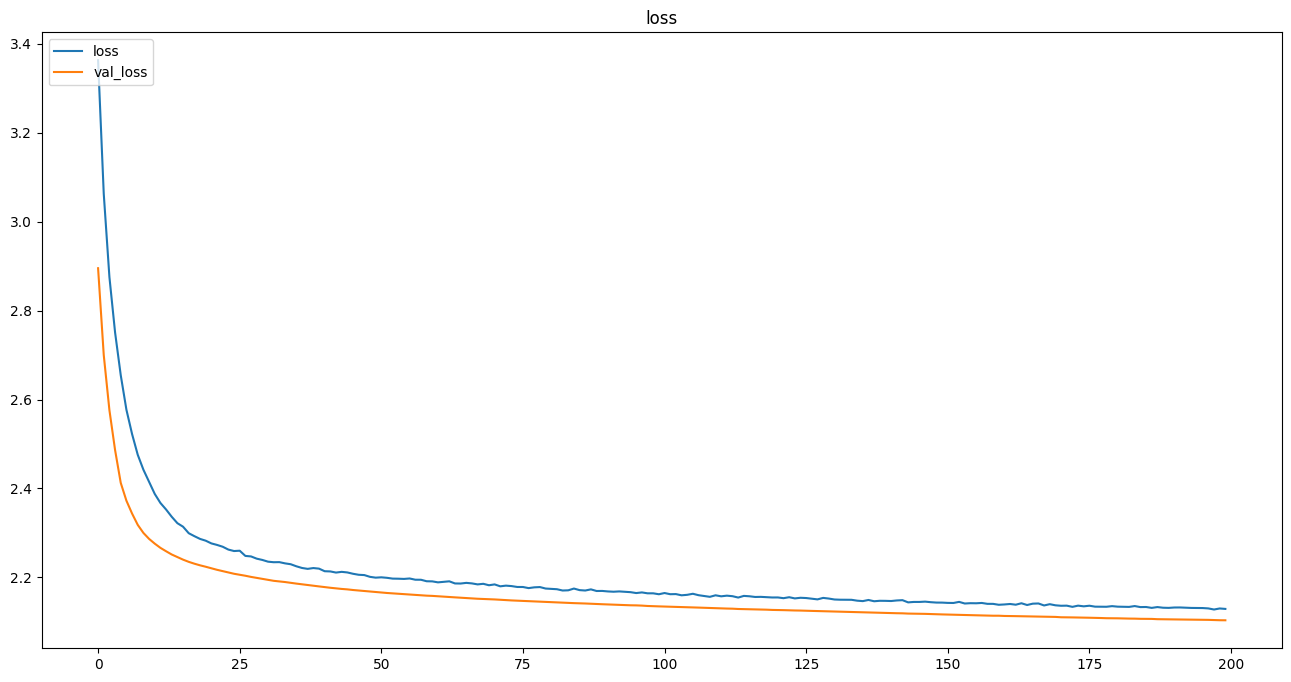

In [19]:
# Save model
wtte.save()

# Plot training history
wtte.plot_history_eval()

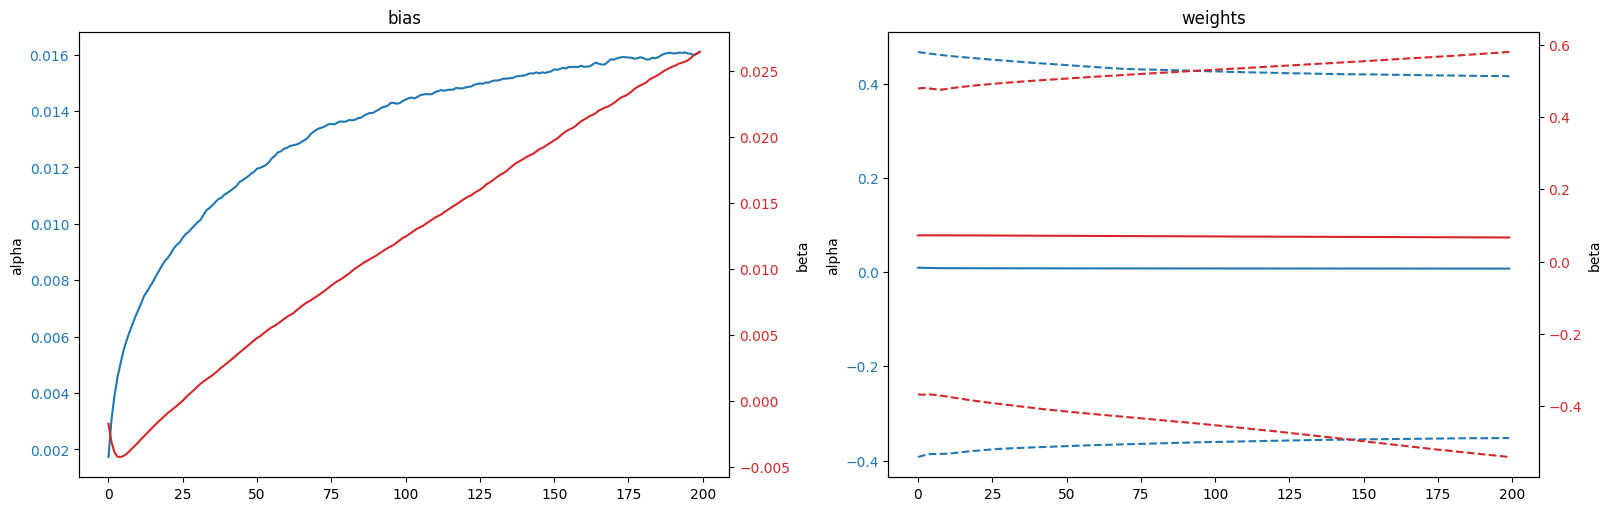

In [20]:
# Plot training weights
wtte.plot_weights()

698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


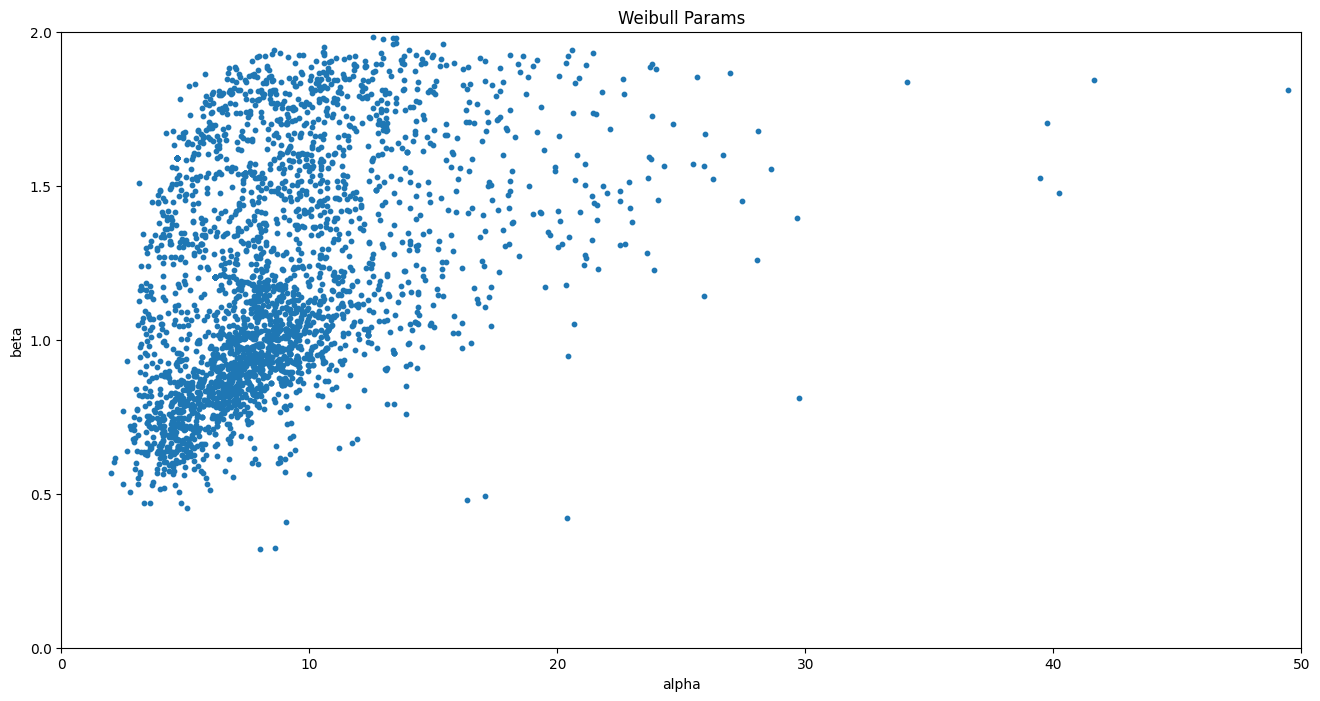

In [21]:
# Build deep validation tensor
# In this case, we need the complete (deep) sequences in order to analize the model performance
x_wtte_deep, y_wtte_deep = wtte.build_seq(d_wtte_test, deep=True)

# Get sequence lengths
wtte.sls = wtte.get_seq_lengths(y_wtte_deep)
# Predict
y_wtte_hat = wtte.predict(x_wtte_deep)
# Set results
wtte.set_results(y_wtte_hat, y_wtte_deep)

# Plot the distribution of Weibull alpha and beta parameters
wtte.plot_params_dist(wtte.results, loc=-1)

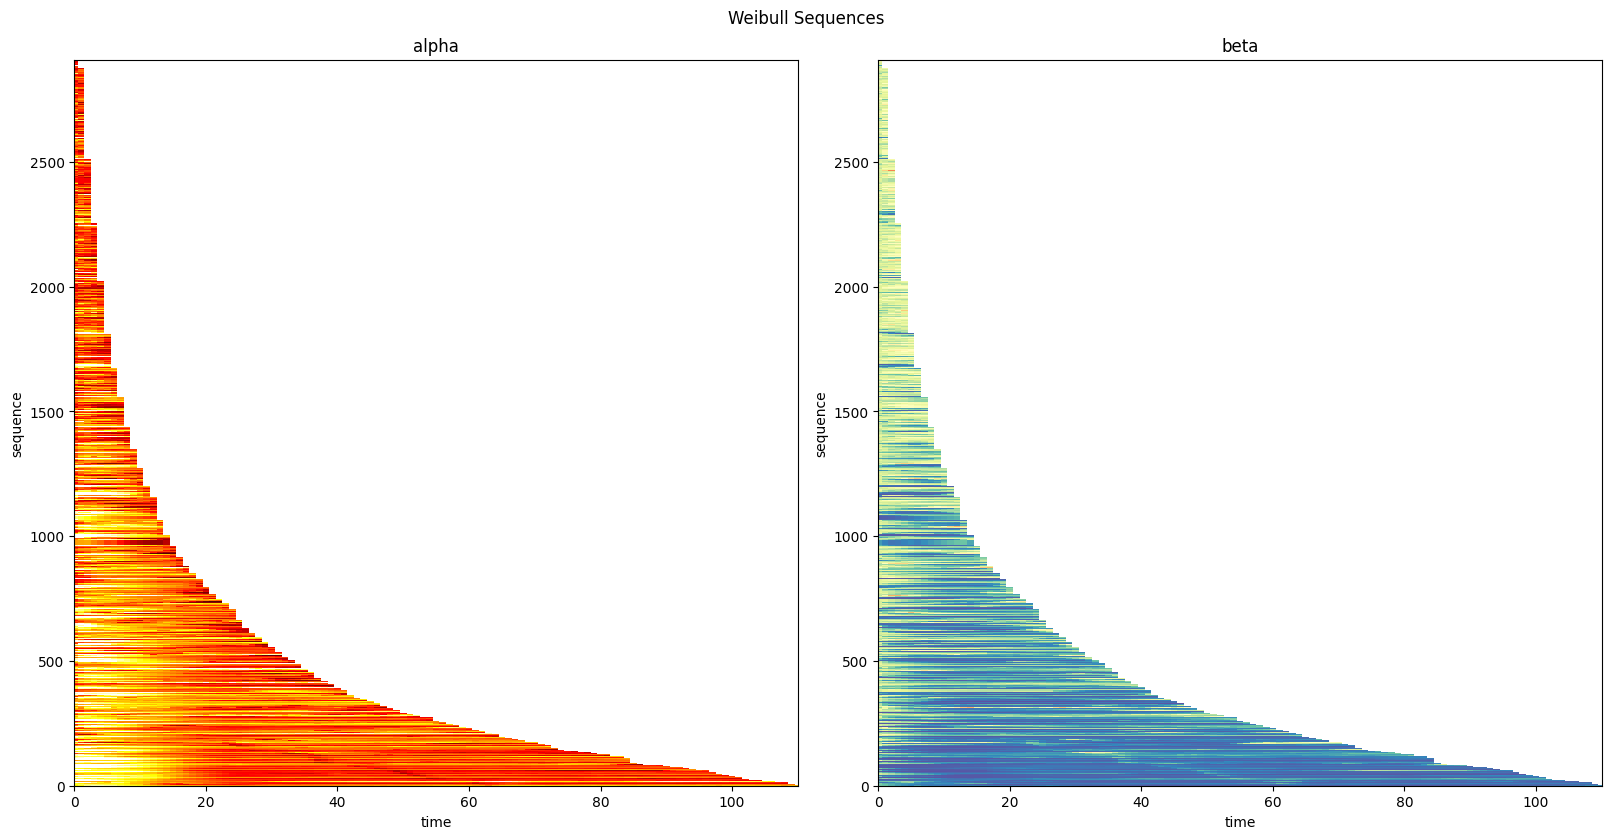

In [22]:
# Plot each customer Weibull alpha and beta parameters over time
wtte.plot_params_seq(wtte.results)

In [23]:
# Prediction results
wtte.results

,id,tfs,wa,wb,pred,true
0,2,0,11.433828,1.010857,0.157717,0
1,2,1,13.168323,1.108345,0.116468,0
2,2,2,12.629801,1.503364,0.060706,0
3,2,3,12.250020,1.739219,0.041860,0
4,2,4,11.538780,1.832818,0.039470,0
...,...,...,...,...,...,...
53694,11624,0,6.818223,0.975902,0.260758,0
53695,11627,0,6.818223,0.975902,0.260758,0
53696,11630,0,7.830257,1.020159,0.220021,0
53697,11634,0,7.394509,1.004688,0.235718,0


In [24]:
# Select random customers from the results
n_samples = 6  # Number of customers
min_periods = 6  # Minimum number of periods recorded

ids = shuffle(
    wtte.results['id'].tolist()
)[:n_samples]

print(ids)

[4641, 2829, 7052, 370, 968, 3852]


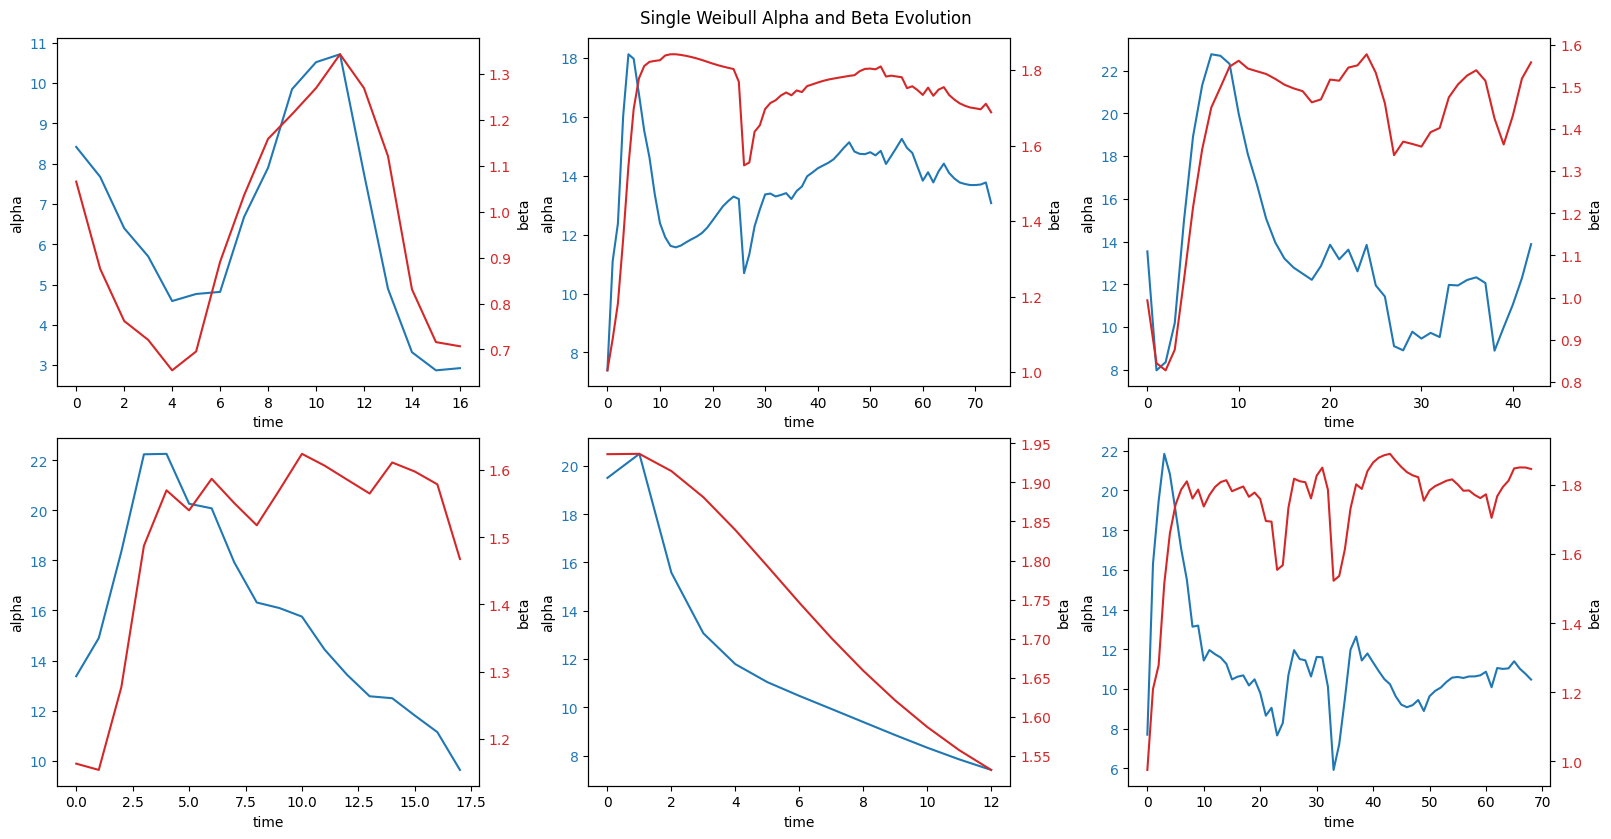

In [25]:
"""
Plot the distribution of the Weibull alpha and beta parameters
for a single customer over time, showing how the parameters change
from one period to the next as the customer info and usage change.

The alpha parameter represents the scale of the Weibull distribution,
which denotes the time it takes for the customer to churn,
while the beta parameter represents the shape of the Weibull distribution,
which is a measure of dispersion, meaning how sure we are about the result.
"""

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), constrained_layout=True)
axs = axs.flatten()

for i, uid in enumerate(ids):
    wtte.plot_single_params(wtte.results, id=uid, ax=axs[i])

plt.suptitle('Single Weibull Alpha and Beta Evolution', y=1.03)

plt.show()

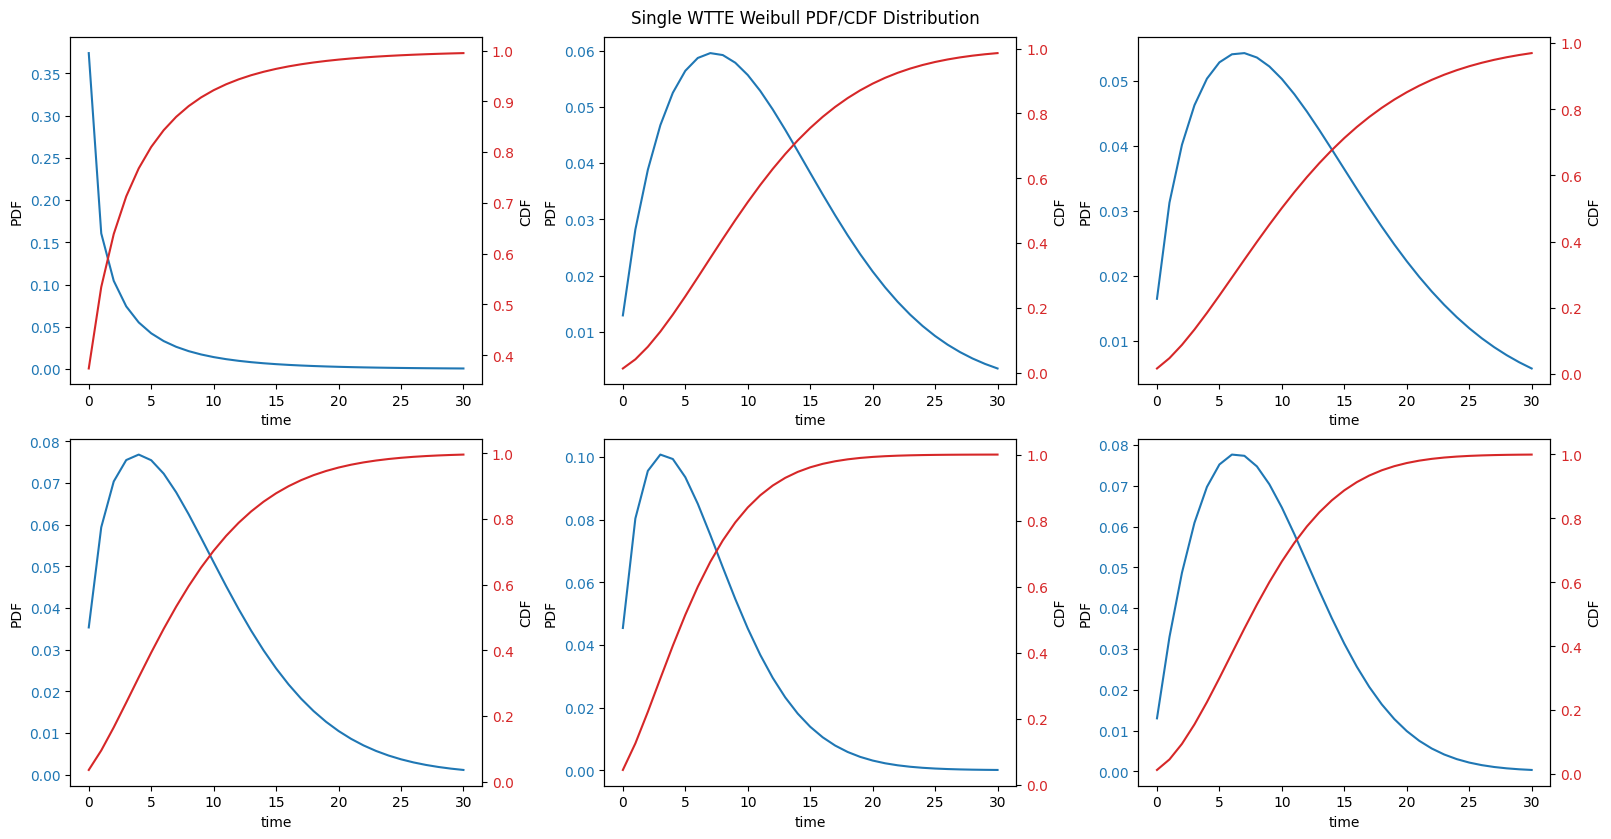

In [26]:
"""
Plot both the probability and cumulative functions for a single customer at a specific period,
showing how the survival of the customer is modeled by the Weibull distribution.

Basically, the probability function shows the probability of the customer
to churn at a given time (the peak of the distribution is the most probable churn period),
while the cumulative function shows the probability of the customer to churn before any given time.
"""

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), constrained_layout=True)
axs = axs.flatten()

for i, uid in enumerate(ids):
    wtte.plot_weibull(wtte.results, id=uid, loc=-1, ax=axs[i])

plt.suptitle('Single WTTE Weibull PDF/CDF Distribution', y=1.03)

plt.show()

In [27]:
# Get the last sequence prediction for each customer
results = (
    wtte.results
    .sort_values(['id', 'tfs'])
    .groupby('id')
    .last()
    .drop(columns=['tfs'])
    .reset_index()
)

show_summary(results, 'true')
results

Shape: 2,910 x 5
    1: 2,284 (78.49%)
    0: 626 (21.51%)


,id,wa,wb,pred,true
0,2,5.266629,1.470163,0.214060,1
1,4,10.213150,1.365566,0.102278,1
2,7,5.909335,1.659737,0.152621,0
3,8,3.312119,1.342109,0.398381,1
4,10,4.494332,1.678359,0.226584,1
...,...,...,...,...,...
2905,11624,6.818223,0.975902,0.260758,0
2906,11627,6.818223,0.975902,0.260758,0
2907,11630,7.830257,1.020159,0.220021,0
2908,11634,7.394509,1.004688,0.235718,0


In [28]:
# Set the WTTE model
model.wtte = wtte

model

In [29]:
# Set model results from WTTE predictions
model.set_results(wtte.results)
# Compute and set model scores
model.set_scores(wtte.results)

model.results

,id,tfs,wa,wb,pred,true,tgt,segment,wa,wb,momentum,cid
0,2,0,11.433828,1.010857,0.157717,0,0,2,11.433828,1.010857,0.0,51643b584bcdb1cc6800001e
1,2,1,13.168323,1.108345,0.116468,0,0,2,13.168323,1.108345,0.0,51643b584bcdb1cc6800001e
2,2,2,12.629801,1.503364,0.060706,0,0,1,12.629801,1.503364,0.0,51643b584bcdb1cc6800001e
3,2,3,12.250020,1.739219,0.041860,0,0,1,12.250020,1.739219,0.0,51643b584bcdb1cc6800001e
4,2,4,11.538780,1.832818,0.039470,0,0,1,11.538780,1.832818,0.0,51643b584bcdb1cc6800001e
...,...,...,...,...,...,...,...,...,...,...,...,...
53694,11624,0,6.818223,0.975902,0.260758,0,0,3,6.818223,0.975902,0.0,660ecafcb6080c67b1acee3f
53695,11627,0,6.818223,0.975902,0.260758,0,0,3,6.818223,0.975902,0.0,660eff0c508579d0d5f9a75b
53696,11630,0,7.830257,1.020159,0.220021,0,0,2,7.830257,1.020159,0.0,660f307c508579d0d5f9bd32
53697,11634,0,7.394509,1.004688,0.235718,0,0,2,7.394509,1.004688,0.0,66105263508579d0d5fca27d


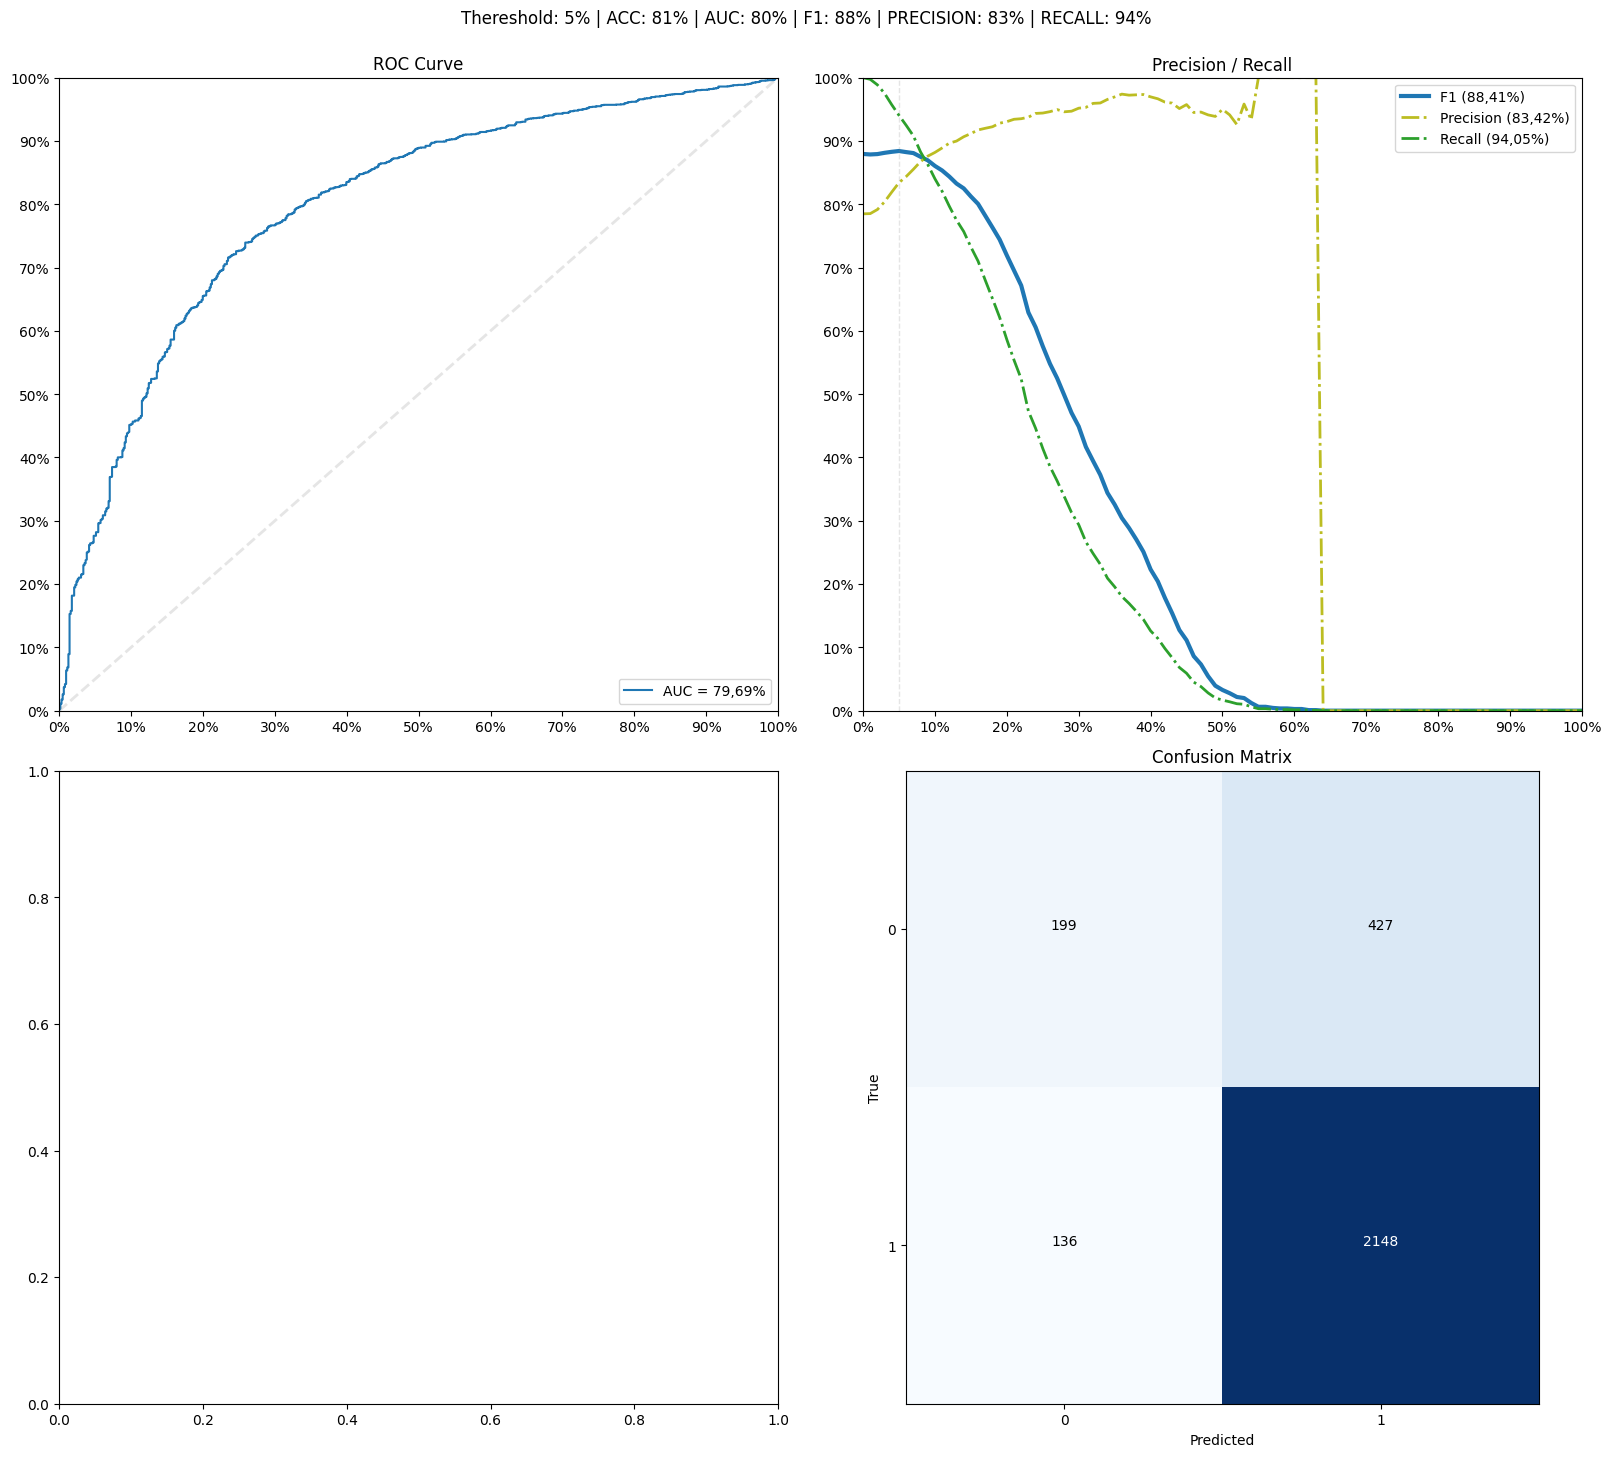

In [30]:
# Plot scores summary
model.plot_scores(wtte.results)

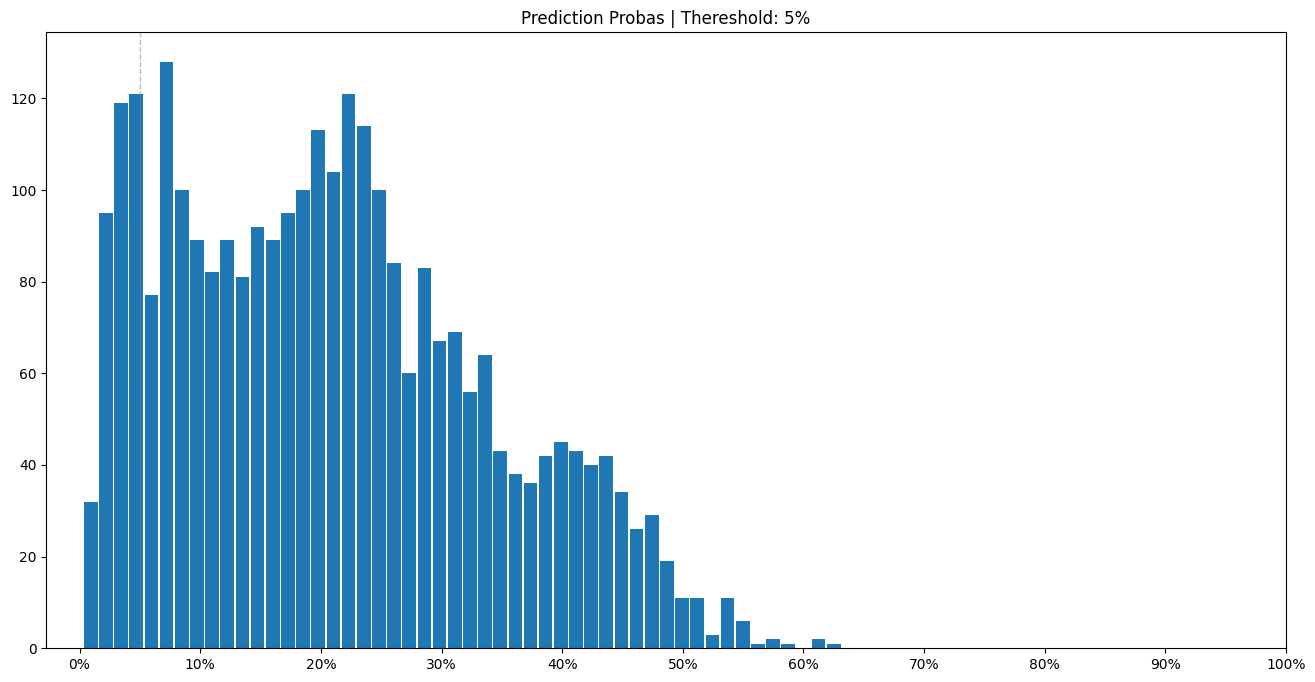

In [31]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram(wtte.results)